In [1]:
import pandas                   as pd
import numpy                    as np
import matplotlib.pyplot        as plt
import seaborn                  as sns
import iirsBenchmark.regressors as regressors

import Auxiliary
import re

from IPython.display  import display
from CriticalDiagrams import draw_cd_diagram


# Setting everything up
Auxiliary.create_global_file_path_variables(results_path='../../results')
Auxiliary.set_mpl_sns_params(abnt=False)

%matplotlib inline

analyzed_path = f'../post hoc analysis files/' # Where to save the plots

## Post processing local explanation robustness

In [2]:
def post_processing_local_explanation_robustness(*, train_or_test, metric):
    """Returns an dataframe where each row is an explainer and each column is a 
    regression method. The value of the cells are the median observed for all
    data sets.
    
    Metric can be one of [stability, infidelity, jaccard].
    """
    
    data = []
    for regressor in regressors.__all__ + ['Feynman_regressor', 'Operon_regressor']:
        
        if train_or_test == 'train':
            df = pd.read_csv(f'{Auxiliary.local_path_train}{regressor}_{metric}.csv')
        else:
            df = pd.read_csv(f'{Auxiliary.local_path_test}{regressor}_{metric}.csv')

        # Converting necessary data. Each column will have the metric
        # evaluated for the observation obs_i
        for col_name in df.columns:
            if col_name.startswith('obs_'):
                df[col_name] = df[col_name].map(Auxiliary.convert_to_array_of_floats)

        df.dropna(inplace=True)

        # The robustness metrics can only have positive values. Here we calculate
        # the mean metric value for the local explanations for a given data set/rep
        mean_metric = df.loc[:, [c for c in df.columns if c.startswith('obs_')]].mean(axis=1, skipna=True)
        mean_metric.name = 'mean_metric_value_in_local_expl'
        
        # Creating a column with the mean
        new_df = df[['dataset', 'explainer']].join(mean_metric)

        # Improving the name of explainers
        new_df['explainer'] = new_df['explainer'].map(lambda x: x.replace('_explainer', ''))

        # Grouping for the given data sets (or all data sets if none is given)
        # And taking the mean over 30 repetitions
        df_metric = new_df.groupby(['dataset', 'explainer']).mean().reset_index(level=[0,1])
        
        # Now taking the median of the data sets
        df_metric = df_metric.groupby(['explainer']).median()['mean_metric_value_in_local_expl']

        # Making extreme outliers become nan
        df_metric = df_metric[df_metric < 5000]
        df_metric.name = regressor.replace('_regressor', '')
        
        data.append(df_metric)
        
    return pd.concat(data, axis=1)

jaccard


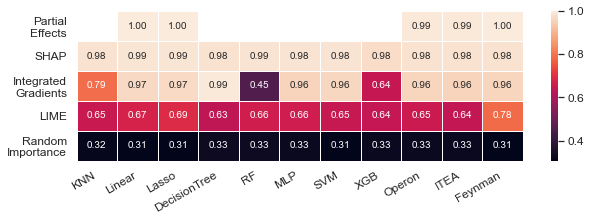

infidelity


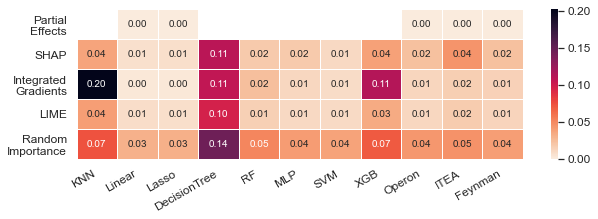

stability


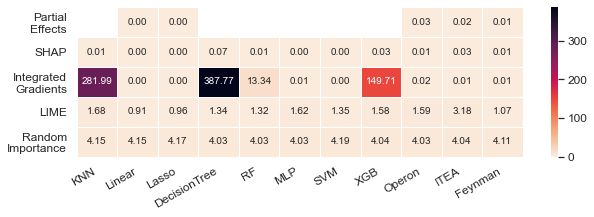

In [3]:
colormaps = {
    'jaccard'    : sns.color_palette("rocket",   as_cmap=True),
    'infidelity' : sns.color_palette("rocket_r", as_cmap=True),
    'stability'  : sns.color_palette("rocket_r", as_cmap=True)
}

for metric in ['jaccard', 'infidelity', 'stability']:
    print(metric)
    
    all_regressors = digest_traintest_results_local_explanations(
        train_or_test='test', metric=metric).T
        
    all_regressors = all_regressors[
        ['PartialEffects', 'SHAP', 'IntegratedGradients', 'LIME', 'RandomImportance']
    ]

    all_regressors.columns = ['\n'.join(re.findall('[A-Z]+[a-z]*', col)) for col in all_regressors.columns]
    
    all_regressors = (all_regressors.T)[
        ['KNN', 'Linear', 'Lasso', 'DecisionTree', 'RF', 'MLP', 'SVM', 'XGB', 'Operon', 'ITEA', 'Feynman']
    ]
    
    fig, axs = plt.subplots(1, 1, figsize=(10, 2.75))
    
    sns.heatmap(all_regressors, linewidths=.5, ax=axs,
        annot=True, fmt=".2f", #english format
        #annot=all_regressors.applymap(lambda x: f"{x:.2f}".replace('.',',')).values, fmt='', # pt-br format
        cmap = colormaps[metric],
    )

    axs.set_xticklabels(
        [s.get_text() for s in axs.get_xticklabels()],
        rotation = 30, fontsize = 12, ha='right')
        
    plt.savefig(f'{analyzed_path}{metric}_heatmap.pdf', bbox_inches='tight')
    plt.show()

## More detailed information about the metrics

In [4]:
def boxplot_cds_explainer(metric, explainer, train_or_test='test'):
    """Will generate a boxplot and a critical diagram for each
    row in the heatmap, allowing to compare the distributions instead
    of only looking the median value over all data sets.
    """
    
    applicable_regressors = ['ITEA_regressor', 'Feynman_regressor', 'Operon_regressor', 'Linear_regressor', 'Lasso_regressor']
    y_size  = 2.0
    cd_size = y_size
    ratio  =  [10, 8]
    
    if explainer is not 'PartialEffects':
        applicable_regressors = regressors.__all__ + ['Feynman_regressor', 'Operon_regressor']
        y_size  = 4
        cd_size = 2.15
        ratio   = [16, 8]
    
    data = []
    for regressor in applicable_regressors:
        if train_or_test == 'train':
            df = pd.read_csv(f'{Auxiliary.local_path_train}{regressor}_{metric}.csv')
        else:
            df = pd.read_csv(f'{Auxiliary.local_path_test}{regressor}_{metric}.csv')

        # Converting necessary data. Each column will have the metric
        # evaluated for the observation obs_i
        for col_name in df.columns:
            if col_name.startswith('obs_'):
                df[col_name] = df[col_name].map(Auxiliary.convert_to_array_of_floats)

        df.dropna(inplace=True)

        # The robustness metrics can only have positive values. Here we calculate
        # the mean metric value for the local explanations for a given data set/rep
        mean_metric = df.loc[:, [c for c in df.columns if c.startswith('obs_')]].mean(axis=1, skipna=True)
        mean_metric.name = 'mean_metric_value_in_local_expl'
        
        # Creating a column with the mean
        new_df = df[['dataset', 'explainer']].join(mean_metric)

        # Improving the name of explainers
        new_df['explainer'] = new_df['explainer'].map(lambda x: x.replace('_explainer', ''))

        df_metric = new_df.groupby(['dataset', 'explainer']).mean().reset_index(level=[0,1])
        
        # Now taking the median of the data sets
        df_metric_pivoted = df_metric.loc[df_metric['explainer']==explainer,
                                          ['dataset', 'mean_metric_value_in_local_expl']]

        # Making extreme outliers become nan
        df_metric_pivoted = df_metric_pivoted[df_metric_pivoted['mean_metric_value_in_local_expl'] < 5000]
        df_metric_pivoted = df_metric_pivoted.set_index('dataset')['mean_metric_value_in_local_expl']
        df_metric_pivoted.name = regressor.replace('_regressor', '')
        
        data.append(df_metric_pivoted)
        
    data =  pd.concat(data, axis=1)
    
    # Sorting x and y axis
    data = data[data.median().sort_values(
        ascending=(False if metric is 'jaccard' else True)).index]

    # Boxplot ----------------------------------------------------------------
    fig, axs = plt.subplots(1, 1, figsize=(6, y_size)) #, gridspec_kw={'height_ratios': [16, 8]})
    
    flierprops = dict(marker='o', markerfacecolor='black', markersize=2,  markeredgecolor='black')
    sns.boxplot(data=data, orient="h",medianprops={'color': 'k'},
        showfliers=False, flierprops=flierprops, ax=axs)

    for box, color in zip(axs.artists, sns.color_palette("Blues", len(axs.artists))):
        box.set_color(color)

    for spine in ['right', 'top', 'bottom']:
        axs.spines[spine].set_visible(False)

    axs.grid()
    
    plt.tight_layout()
    plt.savefig(f'{analyzed_path}{metric}_{explainer}_boxplot.pdf', bbox_inches='tight')
    plt.show()

    # Critical diagrams ----------------------------------
    fig, axs = plt.subplots(1, 1, figsize=(8, cd_size))
    melted_res = pd.melt(data.reset_index(), id_vars=['dataset'])
    melted_res.columns = ['dataset_name', 'classifier_name', 'accuracy']

    if not metric == 'jaccard':
        melted_res['accuracy'] = np.max(melted_res['accuracy']) - melted_res['accuracy']
            
    draw_cd_diagram(
        df_perf=melted_res,
        labels=False, ax=axs, width=8, textspace=1.0, reverse=False)

    plt.tight_layout()
    plt.savefig(f'{analyzed_path}{metric}_{explainer}_criticaldiagram.pdf', bbox_inches='tight')
    plt.show()

jaccard PartialEffects


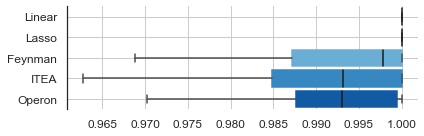

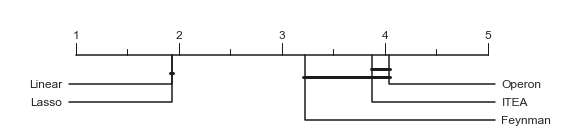

jaccard SHAP


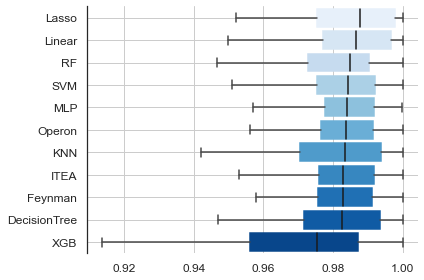

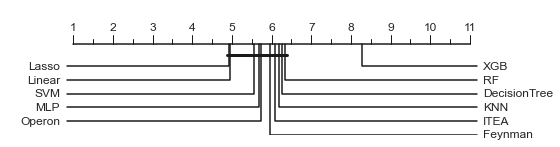

jaccard IntegratedGradients


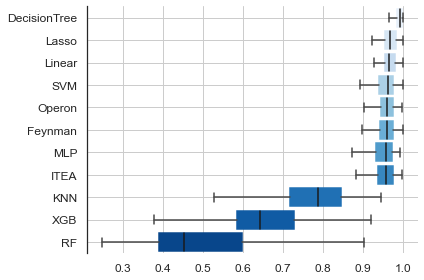

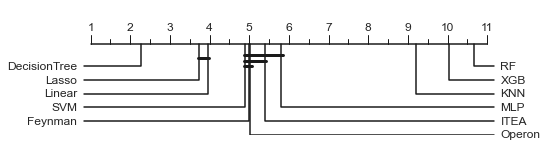

jaccard LIME


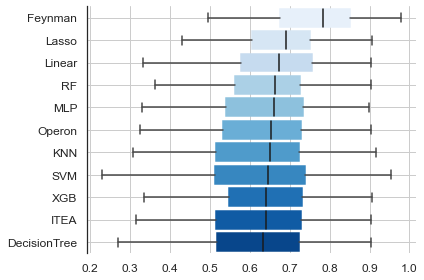

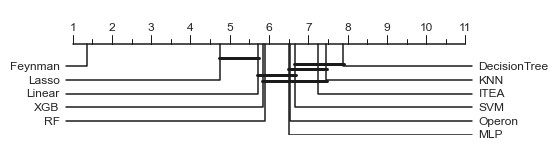

stability PartialEffects


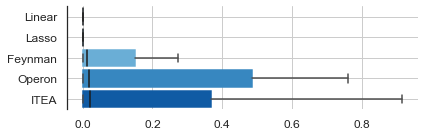

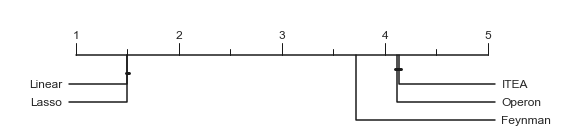

stability SHAP


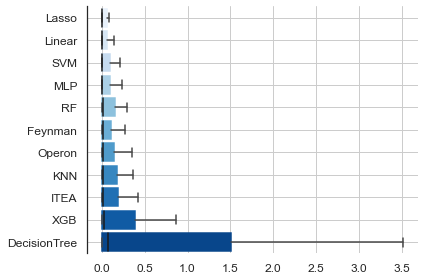

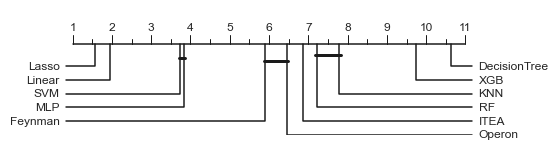

stability IntegratedGradients


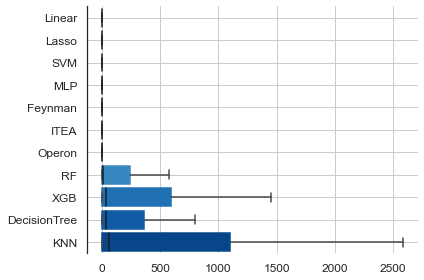

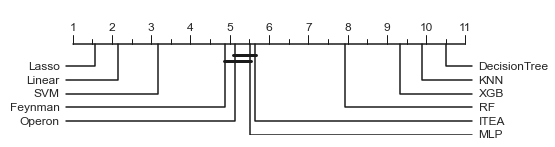

stability LIME


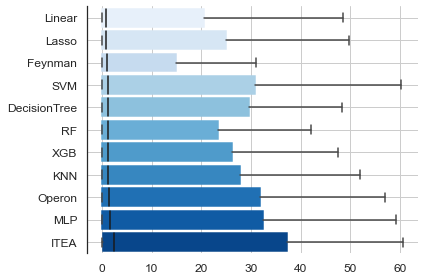

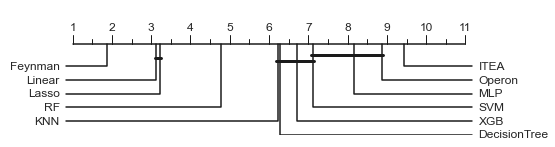

infidelity PartialEffects


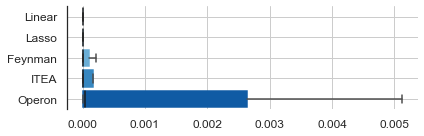

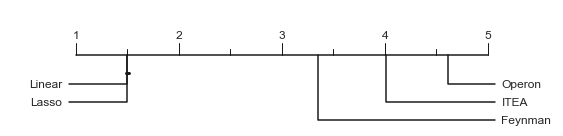

infidelity SHAP


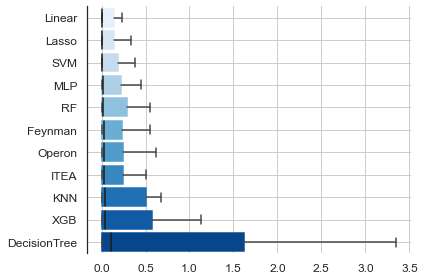

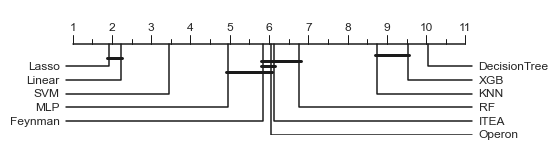

infidelity IntegratedGradients


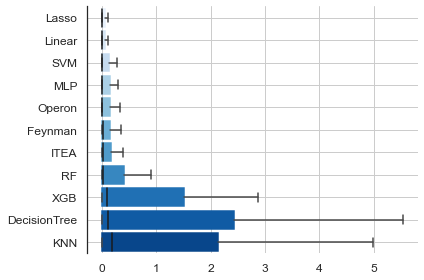

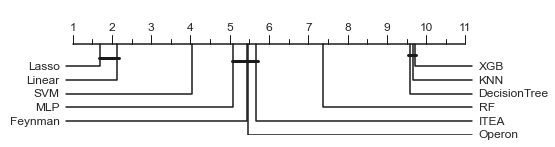

infidelity LIME


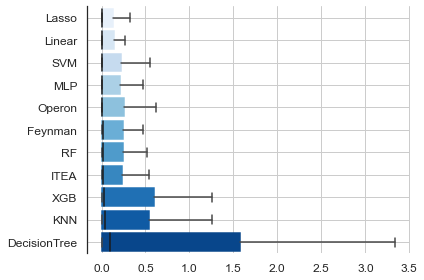

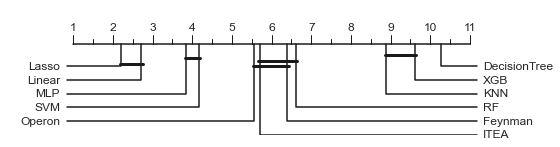

In [5]:
for metric in ['jaccard', 'stability', 'infidelity']:
    for explainer in ['PartialEffects', 'SHAP', 'IntegratedGradients', 'LIME']:
        print(metric, explainer)
    
        boxplot_cds_explainer(metric=metric, explainer=explainer, train_or_test='test')